# Прогнозирование вероятности оттока клиентов фитнес-центра.

## 1. EDA и предобработка

In [1]:
conda install -c plotly plotly-orca

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U pandas
!pip install -U seaborn
!pip install -U matplotlib
!pip install -U plotly.express
!pip install pandas_profiling

Requirement already up-to-date: pandas in c:\users\acer\anaconda3\lib\site-packages (1.3.1)
Requirement already up-to-date: seaborn in c:\users\acer\anaconda3\lib\site-packages (0.11.1)
Requirement already up-to-date: matplotlib in c:\users\acer\anaconda3\lib\site-packages (3.4.2)
Requirement already up-to-date: plotly.express in c:\users\acer\anaconda3\lib\site-packages (0.4.1)


In [3]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy import stats as st
from math import factorial
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Импорт файла

df = pd.read_csv('C:/Users/Acer/OneDrive/Рабочий стол/Яндекс Практикум/Проект 11/gym_churn.csv')

In [5]:
def preprocess(df):
    """Принимает на вход датасет, возвращает случайные 5 строк, общую информацию и число дубликатов"""
    display(df.sample(5))
    display(df.info())
    display(df.duplicated().sum())
    
preprocess(df)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
533,1,1,1,1,1,12,0,30,184.227747,12.0,11,3.629763,3.576972,0
2081,0,0,0,0,1,1,0,32,93.014206,1.0,4,1.249033,1.000031,0
1711,0,1,1,1,1,12,1,27,62.199844,12.0,2,2.169811,2.232871,0
3083,0,1,0,0,1,1,0,22,63.219326,1.0,3,0.626369,0.000000,1
3687,1,1,0,0,0,1,0,29,222.980927,1.0,1,1.840473,1.022087,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

0

**Датасет содержит данные 4000 клиентов, пропущенные значения, дубликаты и категориальные переменные отсутствуют.**

In [6]:
#приведем названия столбцов к нижнему регистру

df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [7]:
#сформируем отчёт с показателями разведочного анализа данных

pandas_profiling.ProfileReport(df, minimal=True)

- **gender**: среднее по столбцу равно 0.51, что означает сбалансированное разделение клиентов по гендерному признаку. Стандартное отклонение также примерно равно 0.5, что логично для бинарной переменной с распределением 50/50.


- **near_location**: 84.5% клиентов проживают или работают в районе, где находится фитнес-центр.


- **partner**: 48.7% клиентов являются сотрудниками компании-партнёра клуба.


- **promo_friends**: только около 30% клиентов пришли по промокоду.


- **phone**: около 10% не оставили свой контактный номер телефона.


- **contract_period**: большинство клиентов (55.2%) приобрели месячный абонемент, 24% - на год и 20.8% - на полгода.


- **group_visits**: большинство (58.8%) никогда не посещали групповые занятия.


- **age**: набор данных о возрасте клиентов представляет собой нормальное распределение - средний возраст типичного посетителя клуба равен медианному и составляет 29 лет. Одинаково редко ходят в фитнес центр как 18и, так и 40-летние.


- **avg_additional_charges_total**: в среднем посетитель тратит 136 у.е. на доп.услуги центр. У распределения признака тяжелый хвост из экстремально больших значений, что говорит о лояльности таких клиентов к комплексному сервису (фитнес-центр, кафе, спорт-товары, косметический и массажный салон).


- **month_to_end_contract**: наиболее распространенные значения срока до окончания абонемента (1, 6, 12) совпадают с видами абонементов, т.е. можно предположить, что датасет сформирован по большей части из вновь пришедших клиентов.


- **lifetime**: распределение времени с момента первого обращения в фитнес-центр подтверждает это предположение и говорит о снижении числа клиентов с увеличением их lifetime, но, учитывая распределение сроков действия абонементов, это кажется вполне закономерным.


- **avg_class_frequency_total**: в среднем клиенты посещают зал 2 раза в неделю. 88 человек ни разу не пришли после покупки абонемента, и лишь единицы появляются в зале более 5 раз в неделю. Т.е. чаще НЕ ходят вообще, чем ходят часто.


- **avg_class_frequency_current_month**: в текущем месяце число тех, кто ни разу за неделю не пришел в зал, выросло с 88 до 181.


- **churn**: в текущем месяце отток клиентов составил 26.5%.

У переменных довольно разные по величине стандартные отклонения. Это говорит о том, что их нужно стандартизировать перед обучением. Для логистической регрессии и дерева это не обязательно, для кластеризации стандартизацию проведем непосредственно перед обучением модели.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [8]:
churn = df.groupby('churn').mean()
churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


*Краткие выводы по группировке:*

---

**У пользователей, попавших в отток, все средние значения признаков (кроме пола и факта указания своего контактного номера) ниже, чем у тех, кто остался клиентом фитнес-зала**, т.е. в признаках таких клиентов чаще встречается ответ "нет". Характеристики бывших клиентов:

- им неудобно добираться до фитнес-зала, т.к. он находится далеко от дома или работы;

- они не являются сотрудниками компаний-партнеров;

- приходят не по рекомендации;

- не посещают групповые занятия;

- приобретают краткосрочные абонементы;

- меньше тратят на доп.услуги центра и реже ходят в зал;

- в среднем на 3 года моложе лояльных пользователей.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток), и тех, кто остался (не попали в отток):

In [9]:
def hist(value, ax):
    sns.set(style='ticks')
    sns.histplot(data = df, 
                 x=value,
                 hue='churn',
                 bins=30,
                 color = '#a7617e',
                 ax=ax) #add
    ax.set_title(value, fontsize=10)
    plt.tight_layout();

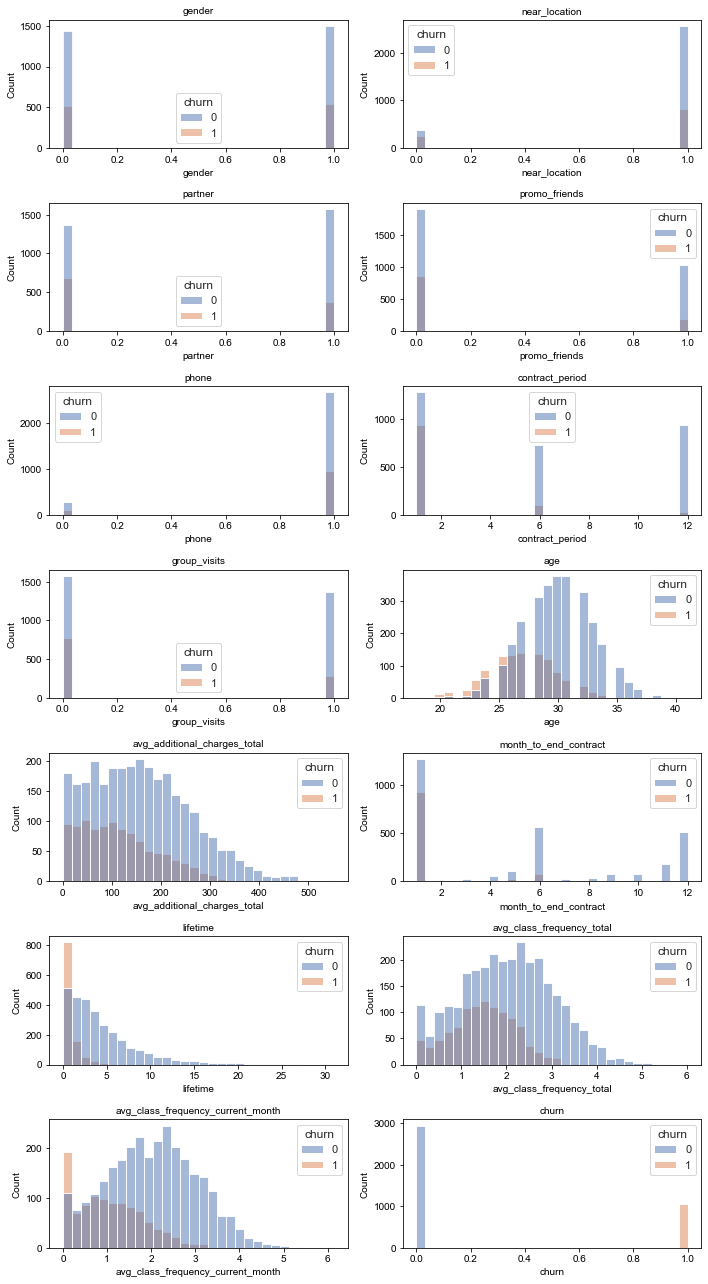

In [10]:
features = df.columns.to_list()

fig, axes = plt.subplots(7, 2, figsize=(10,18))
for i, value in enumerate(features):
    hist(value, axes[i // 2, i % 2])

Распределения гистограмм в целом подтверждают выводы, сделанные выше исходя из средних значений признаков для обеих групп:

- для признака *near_location* данные распределены неравномерно - в основном люди выбирают фитнес-зал поблизости к дому или работе - и чаще остаются клиентами. Те, для кого зал расположен не в пешей доступности, чаще уходят.

- сотрудники компаний-партнеров чаще остаются, чем уходят.

- чаще попадают в отток те, кто пришел по рекомендации.

- в текущем месяце непосещаемость зала удвоилась для тех, кто попал в отток в следующем месяце (в будущем это может быть явным сигналом предстоящего оттока клиента).

Построим и визуализируем матрицу корреляций:

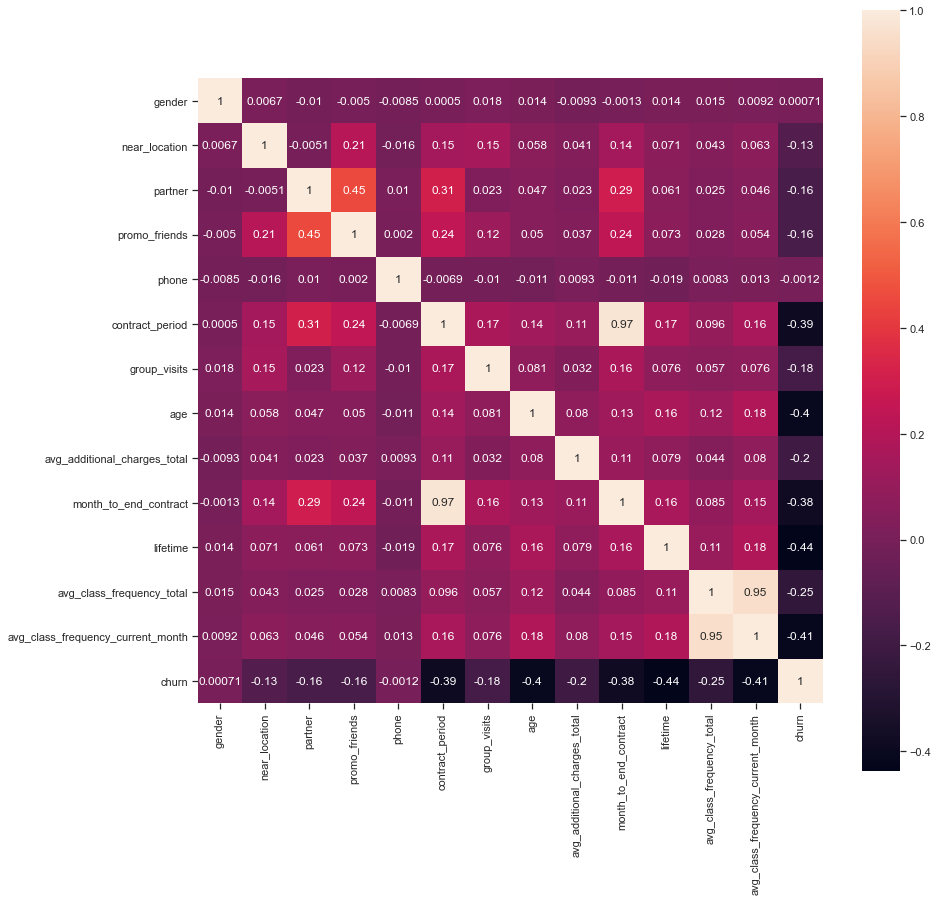

In [11]:
cm = df.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=True, square=True)
plt.show();

Наиболее сильно коррелируют с целевой переменной оттока признаки lifetime, средняя посещаемость в текущем месяце и возраст.
Между собой сильно коррелируют:

- срок абонемента и число месяцев до окончания абонемента (0.97),
- средненедельное число посещений в целом и в текущем месяце (0.95).

Корреляция этих признаков логична и не несет в себе инсайтов для исследования; корреляция для остальных признаков незначительна. Обучим модели сначала на всех признаках, а затем на очищенных от мультиколлинеарности и сравним качество.

## 2. Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

In [12]:
#разделяем датасет на вектор целевой переменной и матрицу признаков

X = df.drop('churn', axis = 1)
y = df['churn']

In [13]:
#разбиваем данные на обучающую и валидационную выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify = y)

Обучим модель на train-выборке логистической регрессией и случайным лесом и спрогнозируем вектор целевой переменной:

In [14]:
#модель логистической регрессии

l_model = LogisticRegression(solver = 'liblinear', random_state=0)
l_model.fit(X_train, y_train)
y_pred_l = l_model.predict(X_test)

In [15]:
#модель случайного леса

rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравним по ним модели:

In [16]:
#метрики классификации для модели, основанной на логистической регрессии

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred_l)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred_l)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred_l)))

Accuracy: 0.93
Precision: 0.89
Recall: 0.83


In [17]:
#метрики классификации для модели случайного леса

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred_rf)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred_rf)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred_rf)))

Accuracy: 0.92
Precision: 0.88
Recall: 0.83


Модель логистической регресии показывает себя немного лучше. Избавимся от мультиколлинеарных признаков и построим прогнозы для каждой модели еще раз.

In [18]:
#среди коррелирующих признаков оставляем наиболее наглядные

df_clean = df.drop(['avg_class_frequency_total', 'month_to_end_contract'], axis = 1)

In [19]:
#разделяем датасет на вектор целевой переменной и матрицу признаков
#разбиваем данные на обучающую и валидационную выборки

X_2 = df_clean.drop('churn', axis = 1)
y_2 = df_clean['churn']

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = 0.2, random_state=0, stratify = y)

In [20]:
#модель логистической регрессии

l_model_2 = LogisticRegression(solver = 'liblinear', random_state=0)
l_model_2.fit(X_2_train, y_2_train)
y_2_pred_l = l_model_2.predict(X_2_test)

In [21]:
#модель случайного леса

rf_model_2 = RandomForestClassifier(random_state=0)
rf_model_2.fit(X_2_train, y_2_train)
y_2_pred_rf = rf_model_2.predict(X_2_test)

In [22]:
#метрики класcификации для модели, основанной на логистической регрессии

print('Accuracy: {:.2f}'.format(accuracy_score(y_2_test, y_2_pred_l)))
print('Precision: {:.2f}'.format(precision_score(y_2_test, y_2_pred_l)))
print('Recall: {:.2f}'.format(recall_score(y_2_test, y_2_pred_l)))

Accuracy: 0.91
Precision: 0.85
Recall: 0.82


In [23]:
#метрики классификации для модели случайного леса

print('Accuracy: {:.2f}'.format(accuracy_score(y_2_test, y_2_pred_rf)))
print('Precision: {:.2f}'.format(precision_score(y_2_test, y_2_pred_rf)))
print('Recall: {:.2f}'.format(recall_score(y_2_test, y_2_pred_rf)))

Accuracy: 0.90
Precision: 0.85
Recall: 0.77


На очищенных данных метрики accuracy и recall более точны **в модели логистической регресии.**

## 3. Кластеризация клиентов

In [24]:
#удалим из датасета столбец с целевой переменной

data = df.drop('churn', axis = 1)

In [25]:
#стандартизируем данные

sc = StandardScaler()
X_sc = sc.fit_transform(data)

In [26]:
#построим матрицу расстояний на стандартизированной матрице признаков

linked = linkage(X_sc, method = 'ward')

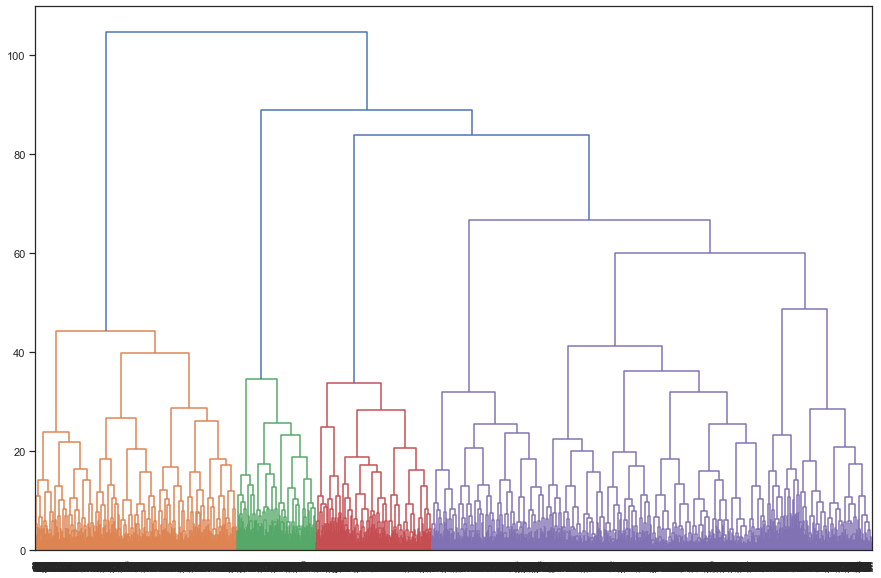

In [27]:
#построение дендрограммы

plt.figure(figsize=(15, 10))
dendrogram(linked, orientation = 'top')
plt.show();

**Предложенное оптимальное число кластеров - 4.**

In [28]:
#обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов (при условии 5 кластеров)

km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_sc)

In [29]:
#сохраняем метки кластера в поле нашего датасета

data['cluster'] = labels

In [30]:
# выводим статистику по средним значениям наших признаков по кластеру

data.groupby('cluster').agg('mean').T

cluster,0,1,2,3,4
gender,0.522078,0.480787,0.559567,0.509603,0.495726
near_location,0.862338,0.812559,0.858002,0.750320,0.943376
partner,0.470130,0.000000,0.338147,1.000000,0.752137
promo_friends,0.306494,0.086223,0.197353,0.451985,0.541667
phone,0.000000,1.000000,0.998797,1.000000,1.000000
contract_period,4.787013,1.866917,2.730445,2.554417,11.352564
group_visits,0.425974,0.325211,0.448857,0.303457,0.564103
age,29.301299,28.145267,30.196149,28.499360,29.993590
avg_additional_charges_total,143.957664,131.369042,164.579011,129.812508,164.563799
month_to_end_contract,4.475325,1.791003,2.519856,2.370038,10.376068


**Особенности кластеров:**

- Все клиенты нулевого кластера не указали свой контактный номер телефона.

- Никто из клиентов первого кластера не является сотрудником компаний-партнеров, при этом все указали свой номер. Имеют самую низкую средненедельную посещаемость по сравнению с клиентами других кластеров. Тратят мало.

- Клиенты 2-го кластера - самые взрослые и лояльные. Готовы тратить на доп.услуги центра больше всех и имеют самую высокую средненедельную посещаемость.

- Для 3-го кластера все клиенты указали свой контактный телефон, все являются сотрудниками компаний-партнеров, меньше остальных тратят на доп.услуги центра.

- В основном клиенты 4-го кластера живут или работают рядом с фитнес-центром, приобретают годовые абонементы и также щедры, как и клиенты 2-го кластера.

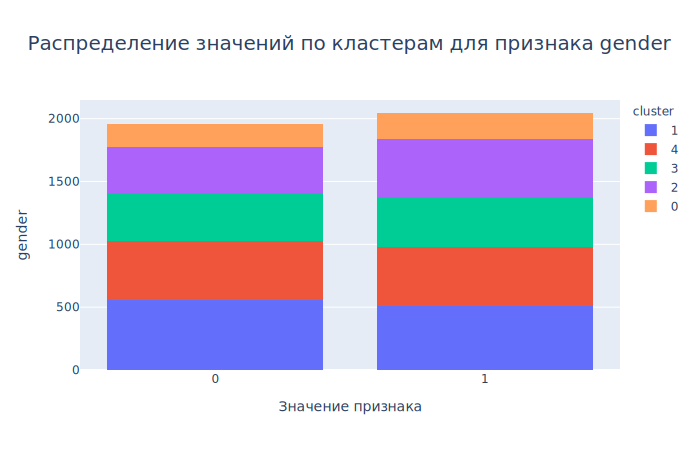

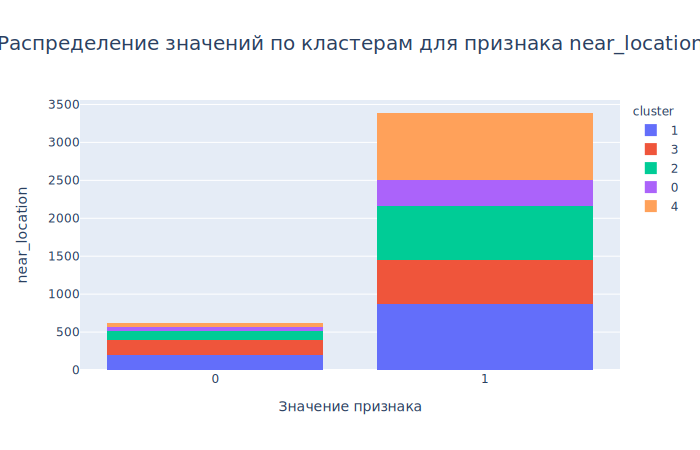

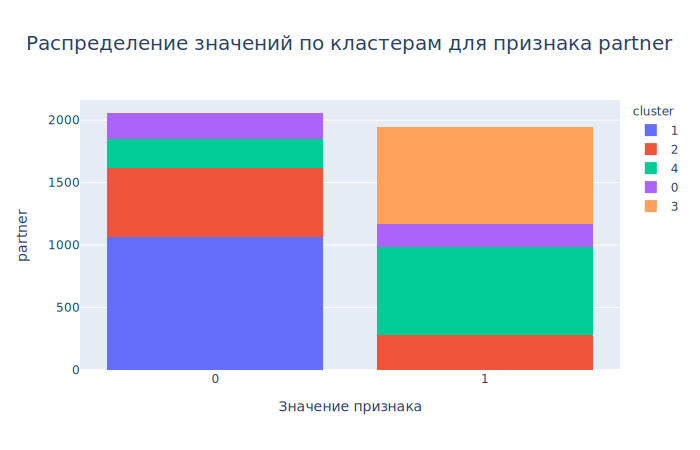

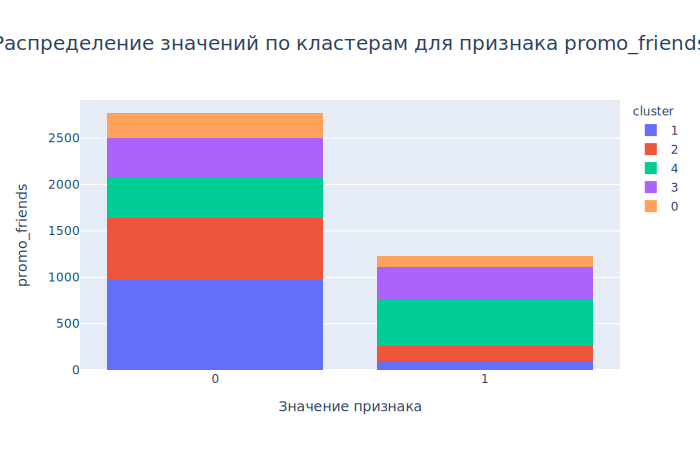

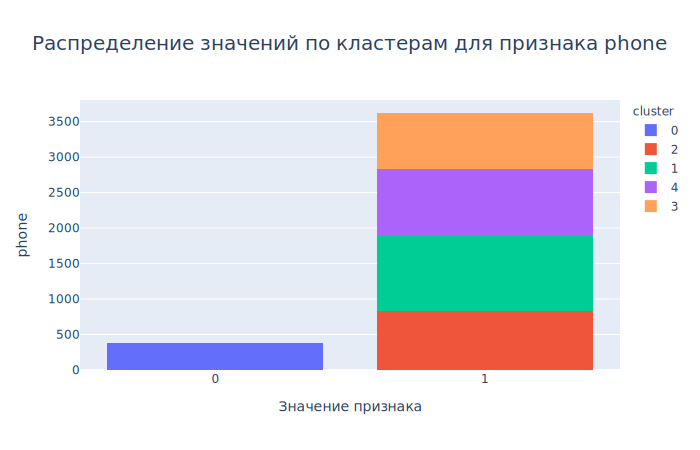

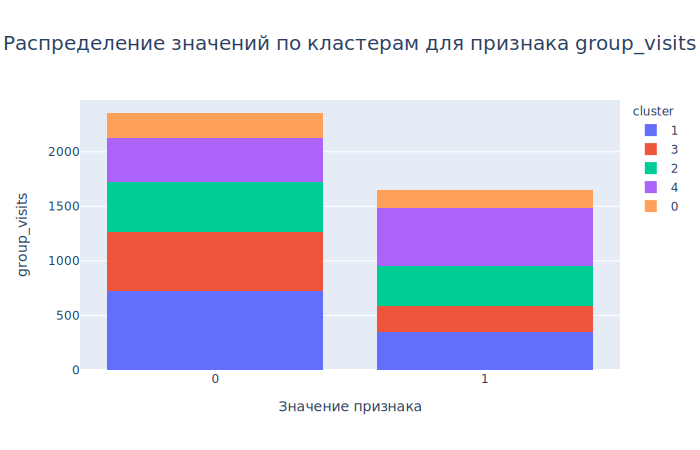

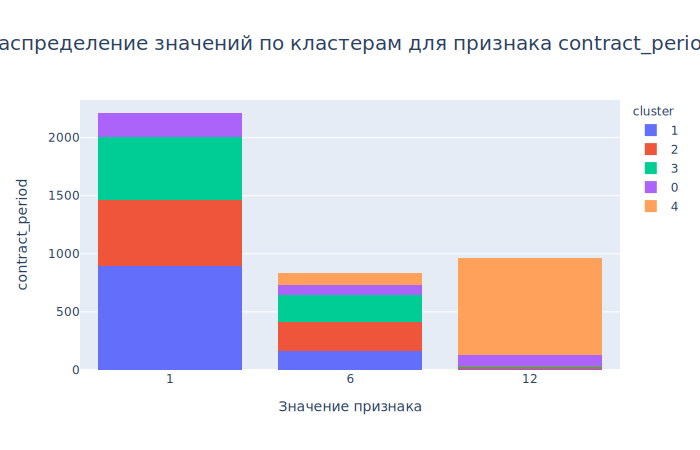

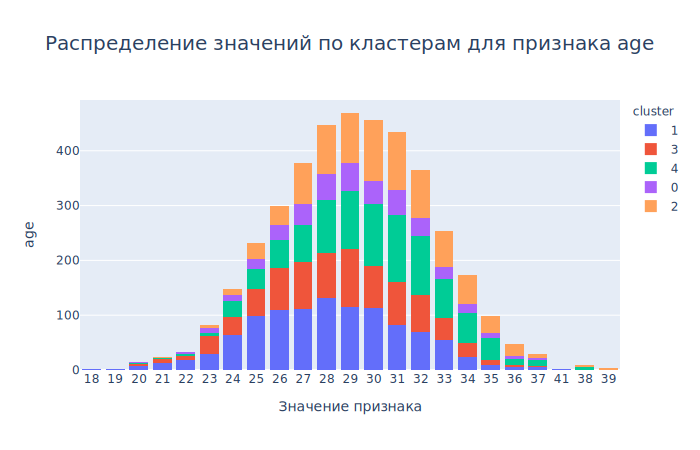

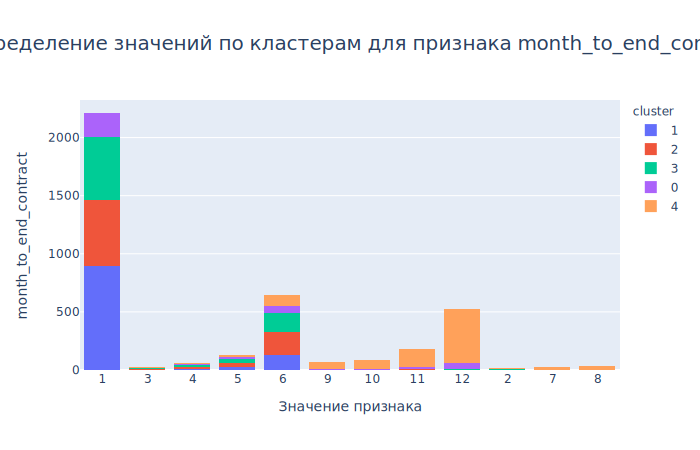

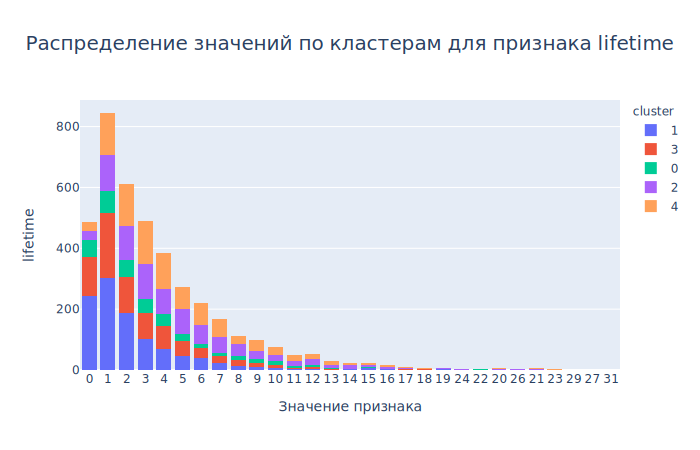

In [31]:
#распределения дискретных признаков для кластеров

discrete_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'contract_period', 'age', 'month_to_end_contract', 'lifetime']

for feature in discrete_features:
    d = pd.DataFrame(data.groupby(feature)['cluster'].value_counts())
    d.rename(columns={'cluster':'number'}, inplace=True)
    d = d.sort_values(by = feature).reset_index()

    
    fig = px.histogram(d, 
            x=feature, 
            y='number',
            color='cluster', 
            barmode='stack',
            title='Распределение значений по кластерам для признака ' + feature)
    
    fig.update_layout(xaxis_title = 'Значение признака',
                  yaxis_title = feature,
                  title = {'font':dict(size=20), 'x':0.5})
    fig.update_xaxes(type='category')
    fig.show(renderer='svg');

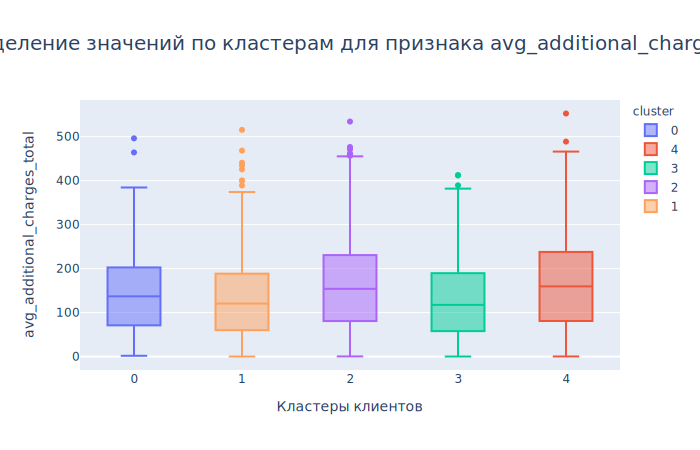

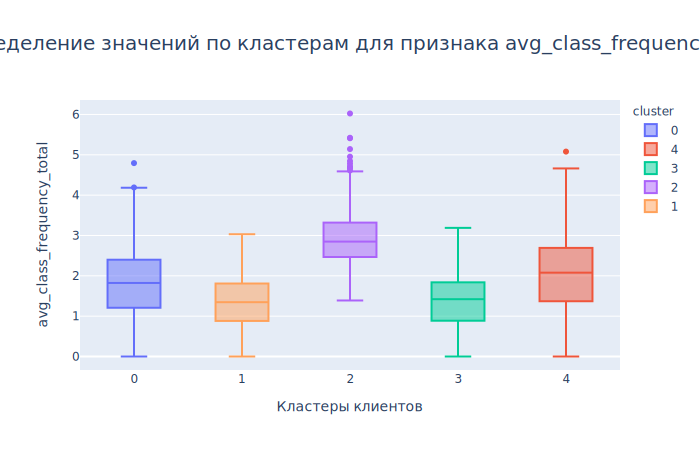

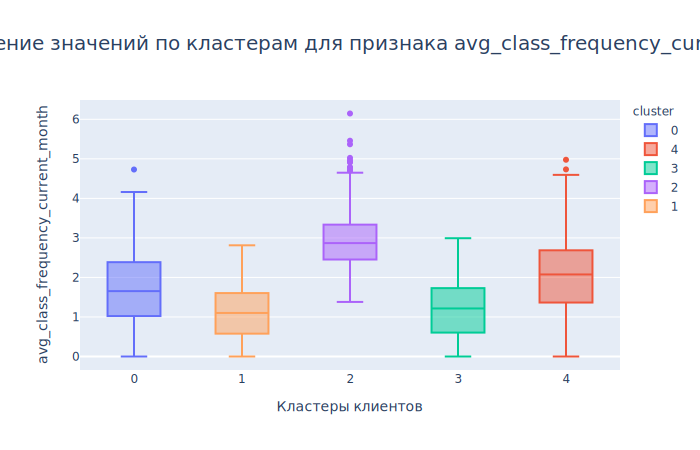

In [32]:
#распределения непрерывных признаков для кластеров

continuous = ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

for feature in continuous:
    fig = px.box(data, 
                 x='cluster', 
                 y=feature, 
                 color='cluster', 
                 title = 'Распределение значений по кластерам для признака ' + feature)
    
    fig.update_layout(xaxis_title = 'Кластеры клиентов',
                  yaxis_title = feature,
                  title = {'font':dict(size=20), 'x':0.5})
    
    fig.show(renderer='svg');

**Графики плотности распределений подтверждают выводы, сделанные из средних значений признаков по кластерам.**

Для каждого полученного кластера посчитаем долю оттока:

In [33]:
#добавим значения кластеров в исходный датасет

df['cluster'] = labels

In [34]:
#для каждого кластера рассчитаем общее число клиентов и число клиентов, попавших в отток
#рассчитаем коэффициент оттока

clusters = df.groupby('cluster', as_index=False).agg({'churn':['count', 'sum']})
clusters.columns = [' '.join(col).strip() for col in clusters.columns.values]
clusters.rename(columns={'churn count':'total', 'churn sum':'churn'}, inplace=True)
clusters['churn_rate'] = round(clusters['churn'] / clusters['total'], 2)
clusters.sort_values(by='churn_rate', ascending=False)

,cluster,total,churn,churn_rate
1,1,1067,587,0.55
3,3,781,309,0.40
0,0,385,103,0.27
2,2,831,40,0.05
4,4,936,22,0.02


Наиболее склонны к оттоку клиенты 1-го кластера (на 55%), а клиенты 2-го и 4-го кластеров самые лояльные.
Стоит отметить, что клиентов первого кластера - большинство (26.7%)

## 4. Выводы и рекомендации по работе с клиентами

***Основные выводы:***

Мы изучили данные 4000 клиентов фитнес-центра (действующих и бывших) и построили модели прогнозирования оттока клиентов и модель кластеризации.

**Для пользователей, попавших в отток, характерны следующие признаки:**

- им неудобно добираться до фитнес-зала, т.к. он находится далеко от дома или работы;

- они не являются сотрудниками компаний-партнеров;

- приходят не по рекомендации;

- не посещают групповые занятия;

- приобретают краткосрочные абонементы;

- меньше тратят на доп.услуги центра и реже ходят в зал;

- в среднем на 3 года моложе лояльных пользователей.

При прогнозировании оттока клиентов в следующем месяце лучше всего себя показала **модель логистической регрессии** - значения метрик accuracy (0.93), precision (0.89) и recall (0.83) оказались выше рассчитанных по модели случайного леса. В целом значения метрик достаточно высоки, что говорит о надежности модели.

---

Мы провели кластеризацию, с помощью которой выделили 5 кластеров клиентов, из которых можно выделить **3 наиболее ярких группы:**

- 1-й кластер: самые редкие гости фитнес-зала - в месяце перед оттоком посещают зал не чаще 1 раза в неделю. Не являются сотрудниками компаний-партнеров и не сильно тратятся на доп.услуги центра. Отток таких клиентов составил 55% в следующем месяце.

- 2-й кластер: самые взрослые (в среднем 30 лет) и лояльные. Готовы тратить на доп.услуги центра больше всех и имеют самую высокую средненедельную посещаемость (3 раза в текущем и предыдущих месяцах). Практически не склонны к оттоку (churn rate = 5%, далее - CR).

- 4-й кластер: живут или работают рядом с фитнес-центром, приобретают годовые абонементы и также щедры, как и клиенты 2-го кластера. Наименее склонны к оттоку (2%).

В текущем месяце клиентская база фитнес-зала состоит по большей части из надежных и лояльных клиентов (44% суммарно для 2 и 4 кластеров) и почти на 27% из клиентов, кто с 55-процентной вероятностью уйдет в следующем месяце.

---

***Рекомендации:***

- т.к. клиенты 0-го кластера в среднем приобретают полугодовые абонементы и уходят спустя пару месяцев занятий, стоит провести опрос (по email, т.к. эти клиенты не указали свой номер) о причинах ухода. По всем остальным признакам они имеют неплохие показатели, поэтому вероятно, что на их отток повлияли внешние факторы.


- средний срок абонементов для клиентов 1-го кластера составляет 1 месяц, т.е. вероятно таких клиентов и не стоит рассматривать как потенциально постоянных. Такой срок абонемента может говорить о том, что человек планирует переезжать, либо хочет в целом попробовать начать заниматься спортом (но не уверен, что продолжит, поэтому берет только на 1 месяц). Т.к. ходят в зал редко, вероятно, что их отток связан с недостатком мотивации. Для такого кластера может быть эффективен запуск рассылки с "призывами к занятиям спортом", информировании о скидках на покупку полугодового абонемента (когда месячный абонемен будет заканчиваться). Также, стоит рассмотреть таргетированную рекламу.


- клиентов 3-го кластера отличает причастность к компаниям-партнерам и экономия на доп.услугах центра. Также, по сравнению с остальными, к этому кластеру относится больше всего тех, для кого фитнес-зал не находится поблизости о дома или работы. Предположительно, приобретение абонемента было связано с компенсацией части стоимости абонемента работодателем, при этом вопрос удобства локации отошел на второй план. В дальнейшем локация стала причиной оттока. Удержать таких клиентов почти невозможно (если нет альтернативного клуба сети поблизости к дому или работе, чтобы предложить замену), компании следует таргетировать свои рекламные кампании в первую очередь на близлежащие жилые комплексы - как показывает 4-й кластер, такие клиенты будут наиболее надежны.